In [2]:
import qiskit
import qiskit_ibm_runtime
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.circuit import Parameter

In [4]:
token = "0e9cd6b0dd6d6561fddb21e70ad56cac43f7a4dd1ec779506bd6c6c40c4afe94974c744e58a733b8b52b9fed25b3925b209452b1a5ab1f80baaa8b33e71ead53"
service = QiskitRuntimeService.save_account(token, instance="GaugeSim", overwrite="True")

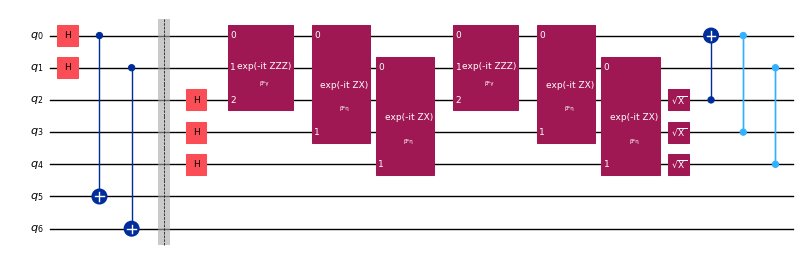

In [6]:
γ = Parameter('γ')
η = Parameter('η')
β = Parameter('β')

X = SparsePauliOp("X")
Z = SparsePauliOp("Z")

qc_sym = QuantumCircuit(7)

qc_sym.h([0,1])
qc_sym.cx(0,5)
qc_sym.cx(1,6)
qc_sym.barrier()

ZZZ = PauliEvolutionGate(Z^Z^Z, time=β*γ)
ZX = PauliEvolutionGate(Z^X, time=β*η)

qc_sym.h([2,3,4])

qc_sym.append(ZZZ,[0,1,2])
qc_sym.append(ZX,[0,3])
qc_sym.append(ZX,[1,4])

qc_sym.append(ZZZ,[0,1,2])
qc_sym.append(ZX,[0,3])
qc_sym.append(ZX,[1,4])


qc_sym.sx([2,3,4])

qc_sym.cx(2,0)
qc_sym.cz(3,0)
qc_sym.cz(4,1)

qc_sym.draw("mpl",scale=0.5)

In [7]:
sim = AerSimulator(method="statevector")

In [8]:
H_sym = SparsePauliOp(["IIIIIZZ","IIIIIXI","IIIIIIX"], coeffs=[γ,η,η])

In [12]:
H_fix = H_sym.assign_parameters({γ:pi/4,η:pi/4})
H_fix = SparsePauliOp(H_fix.paulis, coeffs=np.asarray(H_fix.coeffs, dtype=np.complex128)) #Forcing correct assignment

In [14]:
vals = np.linspace(0.0, 0.4, 11)

In [16]:
pm = generate_preset_pass_manager(backend=sim, optimization_level=3)

In [18]:
results = []  
for val in vals:
    qc = qc_sym.assign_parameters({γ: pi/4, η: pi/4, β: -val})
    isa_qc = pm.run(qc)               
    isa_H = H_fix.apply_layout(isa_qc.layout)
    results.append({"beta": val, "isa_qc": isa_qc, "isa_H": isa_H})

In [20]:
estimator = Estimator(mode=sim, options={"default_shots": 10000})

In [22]:
trotter_steps = 2

In [24]:
approx = []
for item in results:
    beta = item["beta"]
    isa_qc = item["isa_qc"]
    isa_H = item["isa_H"]

    res = estimator.run([(isa_qc, isa_H)]).result()[0]
    ev = res.data.evs
    approx.append((beta*2*trotter_steps, ev))
    print(f"β = {beta*2*trotter_steps:.3f}, Expectation value = {ev}")

β = 0.000, Expectation value = -0.0021991148575128544
β = 0.160, Expectation value = -0.2987654613563894
β = 0.320, Expectation value = -0.5761680926683681
β = 0.480, Expectation value = -0.8213693992810513
β = 0.640, Expectation value = -1.0835353062231197
β = 0.800, Expectation value = -1.2662189190293662
β = 0.960, Expectation value = -1.3953383770919066
β = 1.120, Expectation value = -1.511891464540088
β = 1.280, Expectation value = -1.5766082732040374
β = 1.440, Expectation value = -1.5876038474916019
β = 1.600, Expectation value = -1.579278626959589


In [26]:
gamma = pi/4
eta = pi/4

I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1],[1, 0]])
Z = np.array([[1, 0],[0,-1]])

ZZ = np.kron(Z, Z)
XI = np.kron(X, I)
IX = np.kron(I, X)
H = gamma * ZZ + eta * (XI + IX)

eps, V = np.linalg.eigh(H)

def thermal_average_H(beta: float) -> float:

    w = np.exp(-beta * eps)
    Z = np.sum(w)
    return float(np.sum(eps * w) / Z)

beta_values = np.linspace(0., 1.6, 11)

thermal_averages = np.array([thermal_average_H(b) for b in beta_values])

for b, e in zip(beta_values, thermal_averages):
    print(f"beta = {b:.3f} -> <H>_beta = {e:.10f}")

beta = 0.000 -> <H>_beta = -0.0000000000
beta = 0.160 -> <H>_beta = -0.2925096241
beta = 0.320 -> <H>_beta = -0.5648553211
beta = 0.480 -> <H>_beta = -0.8025558902
beta = 0.640 -> <H>_beta = -0.9993564181
beta = 0.800 -> <H>_beta = -1.1561605854
beta = 0.960 -> <H>_beta = -1.2781480083
beta = 1.120 -> <H>_beta = -1.3720114706
beta = 1.280 -> <H>_beta = -1.4441905915
beta = 1.440 -> <H>_beta = -1.5000813699
beta = 1.600 -> <H>_beta = -1.5438700207


In [28]:
def exp_func(beta, a, b, c):
    return a * np.exp(-b * beta) + c

In [30]:
gs = np.min(np.linalg.eigvalsh(H))

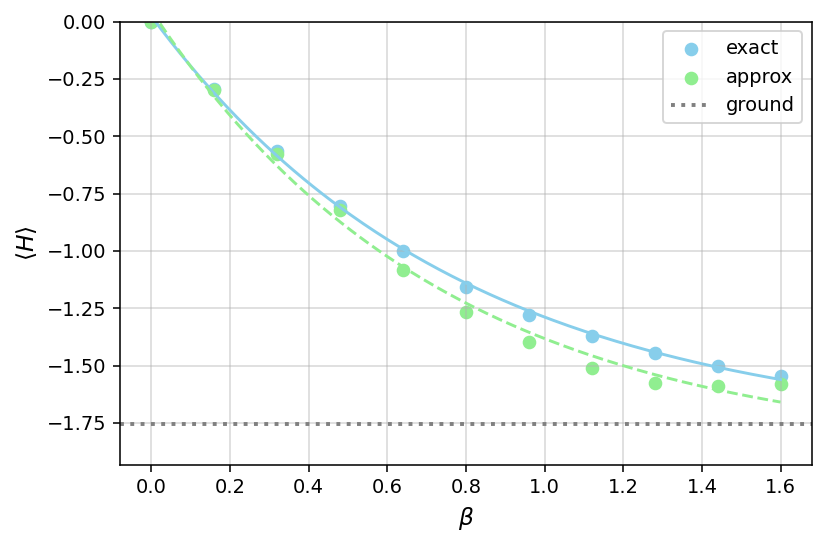

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

betas_circ, evs_circ = zip(*approx)

def exp_func(beta, a, b, c):
    return a * np.exp(-b * beta) + c

params_th, _ = curve_fit(exp_func, beta_values, thermal_averages, p0=(1,1,0))
params_circ, _ = curve_fit(exp_func, betas_circ, evs_circ, p0=(1,1,0))

beta_smooth = np.linspace(min(beta_values), max(beta_values), 200)
thermal_fit = exp_func(beta_smooth, *params_th)
circuit_fit = exp_func(beta_smooth, *params_circ)

plt.figure(figsize=(6,4),dpi=140)

plt.scatter(beta_values, thermal_averages, color='skyblue', label='exact')
plt.scatter(betas_circ, evs_circ, color='lightgreen', label='approx')

plt.plot(beta_smooth, thermal_fit, color='skyblue', linestyle='-')
plt.plot(beta_smooth, circuit_fit, color='lightgreen', linestyle='--')

plt.axhline(y=gs, color='gray', linestyle=':', linewidth=2, label='ground')

ymin = min(np.min(thermal_averages), np.min(evs_circ), gs)
ymax = max(np.max(thermal_averages), np.max(evs_circ))
plt.ylim(ymin - 0.1 * abs(ymin), ymax)

plt.xlabel(r'$\beta$', fontsize=12)
plt.ylabel(r'$\langle H \rangle $', fontsize=12)
plt.grid(True, alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()